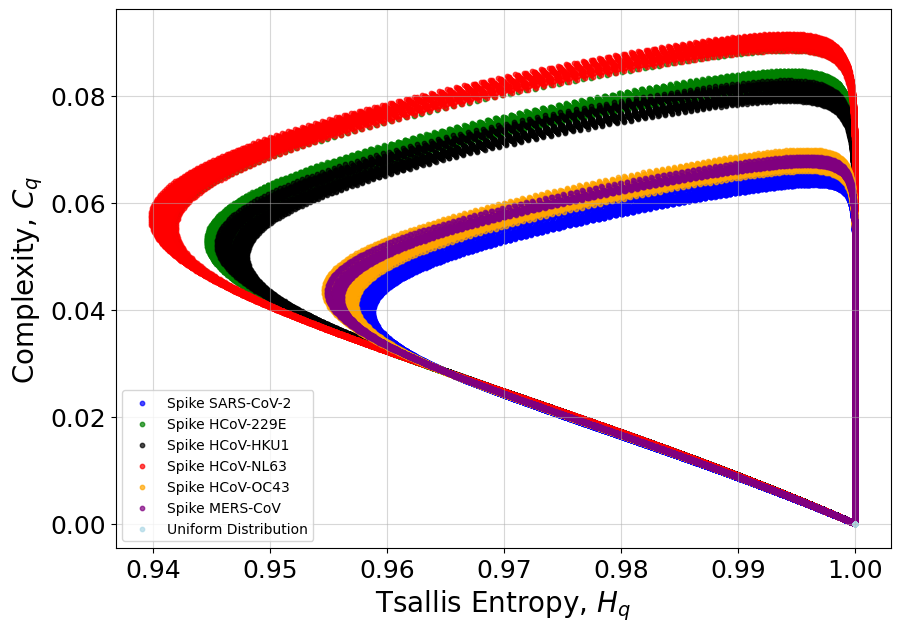

In [3]:
# Importation of essential libraries
import math  # Imports the math module for mathematical operations
import warnings  # Imports warnings to display or suppress warnings
import numpy as np  # Imports NumPy for array manipulation and numerical calculations
import pandas as pd  # Imports Pandas for data table manipulation
import matplotlib.pyplot as plt  # Imports Matplotlib for generating graphs


# Function to calculate the generalized logarithm log_q, used in Tsallis entropy
def logq(x, q=1):
    """
    Computes the generalized logarithm log_q of x for a given parameter q.

    Parameters:
    - x: array-like or scalar, input values.
    - q: float, Tsallis entropy parameter (when q → 1, log_q(x) → log(x)).

    Returns:
    - log_q(x): value of the generalized logarithm.
    """
    x = np.asarray(x, dtype=float)  # Converts x to a NumPy float array to avoid precision errors.
    
    if q == 1:  # Special case when q = 1, log_q(x) reduces to the natural logarithm base 2.
        return np.log2(x)
    else:  # Tsallis generalized logarithm formula for q ≠ 1:
        return (x**(1 - q) - 1) / (1 - q)


# Function to compute Tsallis entropy
def tsallis_entropy(data, k, q=1):
    """
    Computes Tsallis entropy for a given set of probabilities.

    Parameters:
    - data: array-like, list of probabilities.
    - k: int, total number of possible states.
    - q: float or array-like, Tsallis entropy parameter.

    Returns:
    - s: value (or array) of normalized Tsallis entropy.
    """
    probabilities = np.asarray(data)  # Converts 'data' to a NumPy array.
    probabilities = probabilities[probabilities > 0]  # Removes zero values to avoid log(0) issues.

    # Checks if q is a list, tuple, or array to compute entropy for multiple values
    if isinstance(q, (tuple, list, np.ndarray)):
        s = []  # Initializes a list to store entropy values.

        # Loop to compute Tsallis entropy for each q value
        for q_ in q:
            smax = logq(float(k), q_)  # Computes log_q of the normalized maximum entropy.
            lnq_1_over_p = logq(1. / probabilities, q_)  # Applies the log_q transformation to inverse probabilities.
            s.append(np.sum(probabilities * lnq_1_over_p) / smax)  # Computes the normalized entropy.
        
        s = np.asarray(s)  # Converts the list into a NumPy array for better manipulation.

    else:  # If q is a single value, compute it directly without iteration.
        smax = logq(float(k), q)  # Computes log_q for the maximum entropy.
        lnq_1_over_p = logq(1. / probabilities, q)  # Applies the log_q transformation to inverse probabilities.
        s = np.sum(probabilities * lnq_1_over_p) / smax  # Computes the normalized entropy.

    return s  # Returns the computed entropy (normalized by the maximum entropy).


# Function to compute Tsallis complexity-entropy
def tsallis_complexity_entropy(data, k, q=1):
    """
    Computes Tsallis entropy and the associated complexity using Jensen-Tsallis divergence.

    Parameters:
    - data: array-like, list of probabilities.
    - k: int, total number of possible states.
    - q: float or array-like, Tsallis entropy parameter.

    Returns:
    - Array with normalized entropy and complexity.
    """

    # Auxiliary function to compute the maximum Jensen-Tsallis divergence
    def jensen_tsallis_divergence_max(n_states, q):
        """
        Computes the maximum value of Jensen-Tsallis divergence for a given number of states.

        Parameters:
        - n_states: number of possible states.
        - q: Tsallis entropy parameter.

        Returns:
        - Maximum value of Jensen-Tsallis divergence.
        """
        if q == 1:  # Special case: limit for Jensen-Shannon divergence (q → 1)
            return -0.5 * (((n_states + 1) / n_states) * np.log2(n_states + 1) +
                           np.log2(n_states) - 2 * np.log2(2 * n_states))
        else:  # General formula for q ≠ 1
            return ((2**(2 - q)) * n_states - (1 + n_states)**(1 - q) -
                    n_states * (1 + 1 / n_states)**(1 - q) - n_states + 1) / ((1 - q) * (2**(2 - q)) * n_states)

    n = float(k)  # Converts k to float to ensure precision in calculations.

    probabilities = np.asarray(data)  # Converts 'data' into a NumPy array.
    probabilities = probabilities[probabilities != 0]  # Removes zero values to avoid log(0) issues.

    # If q is an array or list, compute entropy and complexity for each q value
    if isinstance(q, (tuple, list, np.ndarray)):
        h_q = tsallis_entropy(probabilities, k, q)  # Computes Tsallis entropy for multiple q values.
        jt_div = []  # List to store Jensen-Tsallis divergence values.
        jt_div_max = []  # List to store maximum Jensen-Tsallis divergence values.

        # Loop to compute entropy and complexity for each q
        for q_, h_q_val in zip(q, h_q):
            n_states_not_occur = n - len(probabilities)  # Number of unobserved states.
            uniform_dist = 1 / n  # Defines the uniform distribution as a reference.
            p = probabilities  # Observed probabilities.

            # Computation of the first part of Jensen-Tsallis divergence
            first_term = (uniform_dist + p) / (2 * p)
            first_term = -0.5 * np.sum(p * logq(first_term, q_))

            # Computation of the second part of Jensen-Tsallis divergence
            second_term = n * (uniform_dist + p) / 2
            second_term = -(0.5 / n) * (np.sum(logq(second_term, q_)) + logq(0.5, q_) * n_states_not_occur)

            jt_div_val = first_term + second_term  # Jensen-Tsallis divergence
            jt_div_max_val = jensen_tsallis_divergence_max(n, q_)  # Maximum Jensen-Tsallis divergence

            jt_div.append(jt_div_val)  # Stores the Jensen-Tsallis divergence value.
            jt_div_max.append(jt_div_max_val)  # Stores the maximum divergence value.

        jt_div = np.asarray(jt_div)  # Converts list to NumPy array.
        jt_div_max = np.asarray(jt_div_max)  # Converts list to NumPy array.

        # Returns a matrix containing entropy and normalized complexity
        return np.asarray([h_q, h_q * jt_div / jt_div_max]).T

    else:  # If q is a single value, compute directly without looping.
        h_q = tsallis_entropy(probabilities, k, q)  # Computes Tsallis entropy.
        n_states_not_occur = n - len(probabilities)  # Number of unobserved states.
        uniform_dist = 1 / n  # Defines the uniform distribution as a reference.
        p = probabilities  # Observed probabilities.

        # Computation of the first part of Jensen-Tsallis divergence
        first_term = (uniform_dist + p) / (2 * p)
        first_term = -0.5 * np.sum(p * logq(first_term, q))

        # Computation of the second part of Jensen-Tsallis divergence
        second_term = n * (uniform_dist + p) / 2
        second_term = -(0.5 / n) * (np.sum(logq(second_term, q)) + logq(0.5, q) * n_states_not_occur)

        jt_div = first_term + second_term  # Jensen-Tsallis divergence
        jt_div_max = jensen_tsallis_divergence_max(n, q)  # Maximum Jensen-Tsallis divergence

        # Returns a matrix containing entropy and normalized complexity
        return np.asarray([h_q, h_q * jt_div / jt_div_max]).T


# Defines the probability distributions for each species, which will be processed for analysis

dist_prob_species = [
    "probabilities_Spike SARS-CoV-2.xlsx",
    "probabilities_Spike HCoV-229E.xlsx",
    "probabilities_Spike HCoV-HKU1.xlsx",
    "probabilities_Spike HCoV-NL63.xlsx",
    "probabilities_Spike HCoV-OC43.xlsx",
    "probabilities_Spike MERS-CoV.xlsx",
    "probabilities_Uniform Distribution.xlsx"  # Uniform distribution for reference
]

# Define different colors for each file in the graph
colors = ['blue', 'green', 'black', 'red', 'orange', 'purple', 'lightblue']

# Set the figure size for the graph
plt.figure(figsize=(10, 7))

# Loop through each Excel file to process the data and generate the graphs
for i, file in enumerate(dist_prob_species):
    entropies = []  # List to store Tsallis entropy values
    complexities = []  # List to store complexity values
    q_values = []  # List to store q values

    try:
        # Read data from the Excel file
        df = pd.read_excel(file)

        # Check if the 'Sequence_ID' column exists in the file
        if "Sequence_ID" not in df.columns:
            raise KeyError(f"The column 'Sequence_ID' was not found in the file {file}")

        # Select the columns representing k-mer frequencies (ignoring 'Sequence_ID')
        kmer_columns = df.columns[1:]

        # Iterate through each row of the DataFrame (each sequence/protein)
        for index, row in df.iterrows():
            # Get the k-mer frequency values, removing NaN values
            p = row[kmer_columns].dropna().tolist()

            # Check if the probabilities sum approximately to 1.0 (normalization)
            if not np.isclose(sum(p), 1.0):
                print(f"Warning: The sum of probabilities in row {index} of file '{file}' is not equal to 1.0. Skipping this row.")
                continue  # Skip the row if the probabilities are not normalized

            # Iterate over q values varying logarithmically between 0.001 and 100
            for q in np.logspace(np.log10(0.001), np.log10(100), num=1000):
                try:
                    # Compute Tsallis entropy and complexity for each q value
                    entropy, complexity = tsallis_complexity_entropy(p, q=q, k=20)

                    # Store the results
                    entropies.append(entropy)
                    complexities.append(complexity)
                    q_values.append(q)
                except ValueError as e:
                    print(f"Error unpacking the result for q={q}: {e}")
                except Exception as e:
                    print(f"Error computing entropy and complexity for q={q}: {e}")

        # Plot the Entropy vs Complexity points for each Excel file
        plt.scatter(entropies, complexities, color=colors[i % len(colors)], s=10, alpha=0.7,
                    label=file.replace('probabilities_', '').replace('.xlsx', ''))

    except FileNotFoundError:
        print(f"Error: The file '{file}' was not found. Check the file path and name.")
    except KeyError as e:
        print(e)

# Graph settings
plt.xticks(fontsize=18)  # Set the font size for X-axis values
plt.yticks(fontsize=18)  # Set the font size for Y-axis values
plt.xlabel("Tsallis Entropy, $H_{q}$", fontsize=20)  # Set the label for the X-axis
plt.ylabel("Complexity, $C_{q}$", fontsize=20)  # Set the label for the Y-axis
plt.grid(True, linestyle='-', alpha=0.5)  # Add a grid to the graph for better visualization
plt.legend(fontsize=10, loc='lower left')  # Add a legend to differentiate each file in the graph

# Save the generated graph as an image file
plt.savefig('Tsallis complexity-entropy graph (Amino Acids).png')

# Display the generated graph
plt.show()
